# MNIST GAN - Hand-written Digit Generation

This notebook implements a Generative Adversarial Network (GAN) using PyTorch to generate hand-written digits from the MNIST dataset.

## Task 2: MNIST Digit Generation GAN

This implementation trains a GAN model on the MNIST dataset to generate realistic hand-written digits (0-9). The trained generator will be integrated into the API for digit generation requests.

## Architecture Specifications

### Generator
- Input: Noise vector of shape (BATCH_SIZE, 100)
- Fully connected layer to 7×7×128, then reshape
- ConvTranspose2D: 128 → 64, kernel size 4, stride 2, padding 1 → output size 14×14
  - Followed by BatchNorm2D and ReLU
- ConvTranspose2D: 64 → 1, kernel size 4, stride 2, padding 1 → output size 28×28
  - Followed by Tanh activation

### Discriminator
- Input: Image of shape (1, 28, 28)
- Conv2D: 1 → 64, kernel size 4, stride 2, padding 1 → output size 14×14
  - Followed by LeakyReLU(0.2)
- Conv2D: 64 → 128, kernel size 4, stride 2, padding 1 → output size 7×7
  - Followed by BatchNorm2D and LeakyReLU(0.2)
- Flatten and apply Linear layer to get a single output (real/fake probability)

## 1. Import Libraries

In [1]:
# Install required packages if needed
# Uncomment and run if packages are missing:
# !pip install torch torchvision matplotlib numpy tqdm torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)

# Check device
device = torch.device('mps' if torch.backends.mps.is_available() 
                      else 'cuda' if torch.cuda.is_available() 
                      else 'cpu')
print(f'Using device: {device}')

Using device: mps


## 2. Define Generator Network

The Generator takes a noise vector and generates a 28×28 image.

In [3]:
class Generator(nn.Module):
    """
    Generator Network for GAN.
    
    Architecture:
    - Input: Noise vector (batch_size, 100)
    - FC layer: 100 -> 7*7*128
    - Reshape to (batch_size, 128, 7, 7)
    - ConvTranspose2d: 128 -> 64, 14x14
    - ConvTranspose2d: 64 -> 1, 28x28
    """
    
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        
        # Fully connected layer: 100 -> 7*7*128
        self.fc = nn.Linear(noise_dim, 7 * 7 * 128)
        
        # Transpose convolution layers
        self.conv_transpose1 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )  # Output: 64 x 14 x 14
        
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv_transpose2 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=1,
            kernel_size=4,
            stride=2,
            padding=1
        )  # Output: 1 x 28 x 28
        
        self.tanh = nn.Tanh()
    
    def forward(self, z):
        """
        Forward pass.
        
        Args:
            z: Noise vector of shape (batch_size, 100)
        
        Returns:
            Generated images of shape (batch_size, 1, 28, 28)
        """
        # FC layer and reshape
        x = self.fc(z)  # (batch_size, 7*7*128)
        x = x.view(-1, 128, 7, 7)  # (batch_size, 128, 7, 7)
        
        # First transpose convolution block
        x = self.conv_transpose1(x)  # (batch_size, 64, 14, 14)
        x = self.bn1(x)
        x = self.relu(x)
        
        # Second transpose convolution block
        x = self.conv_transpose2(x)  # (batch_size, 1, 28, 28)
        x = self.tanh(x)  # Output range: [-1, 1]
        
        return x


# Test the generator
test_gen = Generator(noise_dim=100).to(device)
test_noise = torch.randn(4, 100).to(device)
test_output = test_gen(test_noise)
print(f"Generator output shape: {test_output.shape}")
print(f"Generator output range: [{test_output.min():.3f}, {test_output.max():.3f}]")

# Print model summary
from torchinfo import summary
print("\nGenerator Architecture:")
summary(test_gen, input_size=(4, 100), device=str(device))

Generator output shape: torch.Size([4, 1, 28, 28])
Generator output range: [-1.000, 1.000]

Generator Architecture:


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [4, 1, 28, 28]            --
├─Linear: 1-1                            [4, 6272]                 633,472
├─ConvTranspose2d: 1-2                   [4, 64, 14, 14]           131,136
├─BatchNorm2d: 1-3                       [4, 64, 14, 14]           128
├─ReLU: 1-4                              [4, 64, 14, 14]           --
├─ConvTranspose2d: 1-5                   [4, 1, 28, 28]            1,025
├─Tanh: 1-6                              [4, 1, 28, 28]            --
Total params: 765,761
Trainable params: 765,761
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 108.56
Input size (MB): 0.00
Forward/backward pass size (MB): 1.03
Params size (MB): 3.06
Estimated Total Size (MB): 4.09

## 3. Define Discriminator Network

In [4]:
class Discriminator(nn.Module):
    """
    Discriminator Network for GAN.
    
    Architecture:
    - Input: Images (batch_size, 1, 28, 28)
    - Conv2d: 1 -> 64, 14x14
    - Conv2d: 64 -> 128, 7x7
    - Flatten and FC to single output
    """
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # First convolution layer
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )  # Output: 64 x 14 x 14
        
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        
        # Second convolution layer
        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )  # Output: 128 x 7 x 7
        
        self.bn2 = nn.BatchNorm2d(128)
        
        # Fully connected layer
        self.fc = nn.Linear(128 * 7 * 7, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input images of shape (batch_size, 1, 28, 28)
        
        Returns:
            Predictions of shape (batch_size, 1), range [0, 1]
        """
        # First convolution block
        x = self.conv1(x)  # (batch_size, 64, 14, 14)
        x = self.leaky_relu(x)
        
        # Second convolution block
        x = self.conv2(x)  # (batch_size, 128, 7, 7)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        
        # Flatten and FC layer
        x = x.view(-1, 128 * 7 * 7)  # (batch_size, 128*7*7)
        x = self.fc(x)  # (batch_size, 1)
        x = self.sigmoid(x)
        
        return x


# Test the discriminator
test_disc = Discriminator().to(device)
test_images = torch.randn(4, 1, 28, 28).to(device)
test_pred = test_disc(test_images)
print(f"Discriminator output shape: {test_pred.shape}")
print(f"Discriminator output range: [{test_pred.min():.3f}, {test_pred.max():.3f}]")

# Print model summary
print("\nDiscriminator Architecture:")
summary(test_disc, input_size=(4, 1, 28, 28), device=str(device))

Discriminator output shape: torch.Size([4, 1])
Discriminator output range: [0.333, 0.530]

Discriminator Architecture:


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [4, 1]                    --
├─Conv2d: 1-1                            [4, 64, 14, 14]           1,088
├─LeakyReLU: 1-2                         [4, 64, 14, 14]           --
├─Conv2d: 1-3                            [4, 128, 7, 7]            131,200
├─BatchNorm2d: 1-4                       [4, 128, 7, 7]            256
├─LeakyReLU: 1-5                         [4, 128, 7, 7]            --
├─Linear: 1-6                            [4, 1]                    6,273
├─Sigmoid: 1-7                           [4, 1]                    --
Total params: 138,817
Trainable params: 138,817
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 26.59
Input size (MB): 0.01
Forward/backward pass size (MB): 0.80
Params size (MB): 0.56
Estimated Total Size (MB): 1.37

## 4. Load and Prepare Data

Dataset: MNIST (Hand-written Digits)
Number of training samples: 60000
Number of batches: 469
Image shape: torch.Size([1, 28, 28])


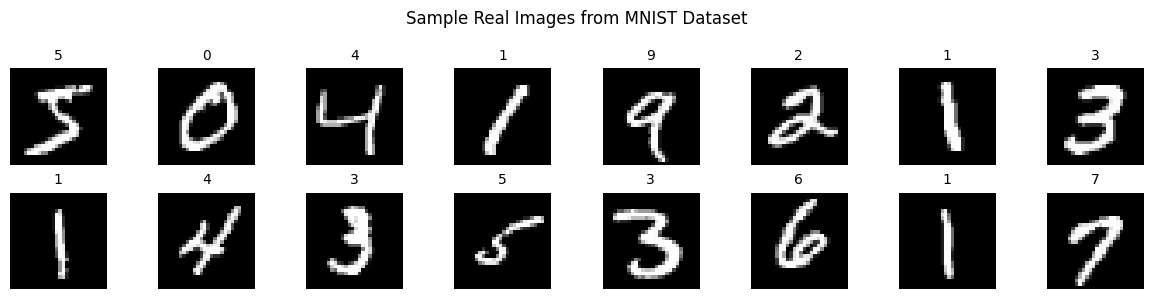

In [6]:
# Hyperparameters
batch_size = 128
noise_dim = 100
num_epochs = 50
learning_rate = 0.0002
beta1 = 0.5

# Data transformation: normalize to [-1, 1] to match Generator's tanh output
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset (hand-written digits)
train_dataset = datasets.MNIST(
    root='../data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

print(f"Dataset: MNIST (Hand-written Digits)")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")
print(f"Image shape: {train_dataset[0][0].shape}")

# Visualize some real images
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    # Denormalize for display
    img = img * 0.5 + 0.5
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'{label}', fontsize=10)
    ax.axis('off')
plt.suptitle("Sample Real Images from MNIST Dataset")
plt.tight_layout()
plt.show()

## 5. Initialize Models and Optimizers

In [7]:
# Initialize Generator and Discriminator
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function: Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizers (using Adam with beta1=0.5 as recommended for GANs)
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Labels for real and fake images
real_label = 1.0
fake_label = 0.0

print("Models initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
print(f"Device: {device}")

Models initialized successfully!
Generator parameters: 765,761
Discriminator parameters: 138,817
Device: mps


## 6. Training Loop

In [ ]:
# Lists to store losses for plotting
g_losses = []
d_losses = []

# Fixed noise for visualization
fixed_noise = torch.randn(64, noise_dim).to(device)

print("Starting training...")

for epoch in range(num_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    
    # Progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (real_images, _) in enumerate(pbar):
        batch_size_actual = real_images.size(0)
        real_images = real_images.to(device)
        
        # Create labels
        real_labels = torch.full((batch_size_actual, 1), real_label, dtype=torch.float, device=device)
        fake_labels = torch.full((batch_size_actual, 1), fake_label, dtype=torch.float, device=device)
        
        # ========================================
        # Train Discriminator
        # ========================================
        optimizer_d.zero_grad()
        
        # Train on real images
        output_real = discriminator(real_images)
        loss_d_real = criterion(output_real, real_labels)
        
        # Train on fake images
        noise = torch.randn(batch_size_actual, noise_dim).to(device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())  # Detach to avoid training G
        loss_d_fake = criterion(output_fake, fake_labels)
        
        # Total discriminator loss
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optimizer_d.step()
        
        # ========================================
        # Train Generator
        # ========================================
        optimizer_g.zero_grad()
        
        # Generate fake images and get discriminator's opinion
        output_fake_for_g = discriminator(fake_images)
        loss_g = criterion(output_fake_for_g, real_labels)  # Generator wants D to think they're real
        
        loss_g.backward()
        optimizer_g.step()
        
        # Track losses
        epoch_g_loss += loss_g.item()
        epoch_d_loss += loss_d.item()
        
        # Update progress bar
        pbar.set_postfix({
            'D_loss': f'{loss_d.item():.4f}',
            'G_loss': f'{loss_g.item():.4f}'
        })
    
    # Average losses for the epoch
    avg_g_loss = epoch_g_loss / len(train_loader)
    avg_d_loss = epoch_d_loss / len(train_loader)
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}")
    
    # Generate and display sample images every 5 epochs
    if (epoch + 1) % 5 == 0:
        generator.eval()
        with torch.no_grad():
            fake_samples = generator(fixed_noise).cpu()
            # Denormalize
            fake_samples = fake_samples * 0.5 + 0.5
            
            # Plot
            fig, axes = plt.subplots(4, 8, figsize=(12, 6))
            for idx, ax in enumerate(axes.flat):
                if idx < len(fake_samples):
                    ax.imshow(fake_samples[idx].squeeze(), cmap='gray')
                ax.axis('off')
            plt.suptitle(f"Generated Images - Epoch {epoch+1}")
            plt.tight_layout()
            plt.show()
        generator.train()

print("Training completed!")

## 7. Visualize Training Progress

In [8]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()

# Show loss statistics
print(f"Final Generator Loss: {g_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {d_losses[-1]:.4f}")
print(f"Average Generator Loss: {np.mean(g_losses):.4f}")
print(f"Average Discriminator Loss: {np.mean(d_losses):.4f}")

NameError: name 'g_losses' is not defined

<Figure size 1000x500 with 0 Axes>

## 8. Generate New Hand-written Digits

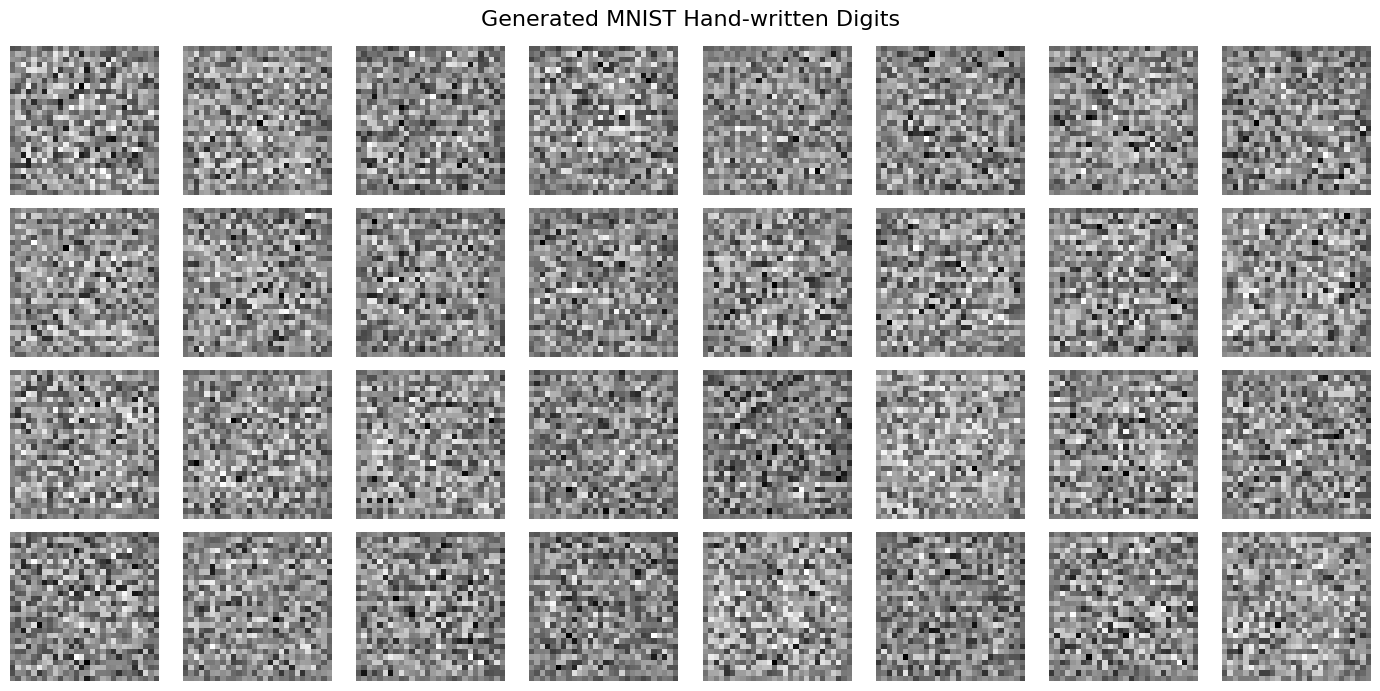

In [9]:
# Generate new images with the trained generator
generator.eval()

num_samples = 32
with torch.no_grad():
    # Generate random noise
    noise = torch.randn(num_samples, noise_dim).to(device)
    
    # Generate fake images
    generated_images = generator(noise).cpu()
    
    # Denormalize to [0, 1] range
    generated_images = generated_images * 0.5 + 0.5

# Display generated images
fig, axes = plt.subplots(4, 8, figsize=(14, 7))
for idx, ax in enumerate(axes.flat):
    ax.imshow(generated_images[idx].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle("Generated MNIST Hand-written Digits", fontsize=16)
plt.tight_layout()
plt.show()

## 9. Compare Real vs Generated Images

In [ ]:
# Compare real and generated images side by side
fig, axes = plt.subplots(4, 8, figsize=(14, 7))

# Get some real images
real_images_list = []
for i in range(16):
    img, _ = train_dataset[i]
    # Denormalize
    img = img * 0.5 + 0.5
    real_images_list.append(img.squeeze().numpy())

# Generate fake images
with torch.no_grad():
    noise = torch.randn(16, noise_dim).to(device)
    fake_images = generator(noise).cpu()
    fake_images = fake_images * 0.5 + 0.5

fake_images_list = [img.squeeze().numpy() for img in fake_images]

# Plot real and fake images
for idx in range(16):
    # Real images in first two rows
    row = idx // 8
    col = idx % 8
    axes[row, col].imshow(real_images_list[idx], cmap='gray')
    axes[row, col].axis('off')
    if idx < 8:
        axes[row, col].set_title('Real', fontsize=8)
    
    # Fake images in last two rows
    row = idx // 8 + 2
    axes[row, col].imshow(fake_images_list[idx], cmap='gray')
    axes[row, col].axis('off')
    if idx < 8:
        axes[row, col].set_title('Generated', fontsize=8)

plt.suptitle("Real vs Generated Images Comparison", fontsize=16)
plt.tight_layout()
plt.show()

## 10. Save Models

In [ ]:
# Save the trained models
import os

# Create directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save generator
torch.save({
    'epoch': num_epochs,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer_g.state_dict(),
    'g_losses': g_losses,
}, '../models/generator_gan.pth')

# Save discriminator
torch.save({
    'epoch': num_epochs,
    'model_state_dict': discriminator.state_dict(),
    'optimizer_state_dict': optimizer_d.state_dict(),
    'd_losses': d_losses,
}, '../models/discriminator_gan.pth')

print("Models saved successfully!")
print("- Generator saved to: ../models/generator_gan.pth")
print("- Discriminator saved to: ../models/discriminator_gan.pth")